In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [103]:
df_customers = pd.read_csv('dim_customer.csv')
df_delivery_partners = pd.read_csv('dim_delivery_partner_.csv')
df_menu_items = pd.read_csv('dim_menu_item.csv')
df_restaurants = pd.read_csv('dim_restaurant.csv')
df_delivery_performance = pd.read_csv('fact_delivery_performance.csv')
df_order_item = pd.read_csv('fact_order_items.csv')
df_orders = pd.read_csv('fact_orders.csv')
df_ratings = pd.read_csv('fact_ratings.csv')

In [104]:
# Merge orders with customers
df_orders_master = df_orders.merge(df_customers, on='customer_id', how='left')

# Merge with restaurants
df_orders_master = df_orders_master.merge(df_restaurants, on='restaurant_id', how='left')

# Merge with delivery performance
df_orders_master = df_orders_master.merge(df_delivery_performance, on='order_id', how='left')

# Merge with ratings
df_orders_master = df_orders_master.merge(df_ratings[['order_id', 'rating', 'review_text', 'sentiment_score']], on='order_id', how='left')

In [105]:
# Merge order items with menu items
df_order_items_master = df_order_item.merge(df_menu_items, on='menu_item_id', how='left')

In [106]:
# Rename columns for clarity
df_orders_master.rename(columns={
    'city_x': 'customer_city',
    'city_y': 'restaurant_city',
    'avg_prep_time_min': 'avg_prep_time',
}, inplace=True)

df_order_items_master.rename(columns={
    'restaurant_id_x': 'restaurant_id',
    'restaurant_id_y': 'restaurant_id_menu',
}, inplace=True)

In [107]:
# Check for nulls
print(df_orders_master.isnull().sum())
print(df_order_items_master.isnull().sum())

# Convert timestamps
df_orders_master['order_timestamp'] = pd.to_datetime(df_orders_master['order_timestamp'])
df_orders_master['signup_date'] = pd.to_datetime(df_orders_master['signup_date'])

# Create delivery delay metric
df_orders_master['delivery_delay_mins'] = df_orders_master['actual_delivery_time_mins'] - df_orders_master['expected_delivery_time_mins']

order_id                           0
customer_id                        0
restaurant_id                      0
delivery_partner_id             5635
order_timestamp                    0
subtotal_amount                    0
discount_amount                    0
delivery_fee                       0
total_amount                       0
is_cod                             0
is_cancelled                       0
signup_date                     5053
customer_city                   5053
acquisition_channel             5053
restaurant_name                    0
restaurant_city                    0
cuisine_type                       0
partner_type                       0
avg_prep_time                      0
is_active                          0
actual_delivery_time_mins          0
expected_delivery_time_mins        0
distance_km                        0
rating                         80341
review_text                    80341
sentiment_score                80341
dtype: int64
order_id              0
i

/tmp/ipykernel_200/1944452190.py:7: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_orders_master['signup_date'] = pd.to_datetime(df_orders_master['signup_date'])


In [108]:
df_orders_master['customer_city'].fillna('Unknown', inplace=True)
df_orders_master['acquisition_channel'].fillna('Unknown', inplace=True)
df_orders_master['review_text'].fillna('Unknown', inplace=True)

In [109]:
pre_crisis_end = pd.to_datetime('2025-05-31')
crisis_end = pd.to_datetime('2025-09-30')

df_orders_master['order_timestamp'] = pd.to_datetime(df_orders_master['order_timestamp'])

df_orders_master['phase'] = df_orders_master['order_timestamp'].apply(
    lambda x: 'pre_crisis' if x <= pre_crisis_end 
    else 'crisis' if x <= crisis_end 
    else 'recovery')

# Predicting Valuable Restaurant Partnerships

In [110]:
df_orders_master['delivery_time_minutes'] = df_orders_master['actual_delivery_time_mins']
df_orders_master['sla_met'] = df_orders_master['delivery_time_minutes'] <= 45

# Aggregate metrics by restaurant
restaurant_metrics = df_orders_master.groupby(['restaurant_name', 'phase']).agg({
    'order_id': 'count',
    'rating': 'mean',
    'sla_met': 'mean'
}).reset_index()

# Pivot for comparison
restaurant_pivot = restaurant_metrics.pivot(index='restaurant_name', columns='phase', values='order_id').fillna(0)
restaurant_pivot['crisis_retention_rate'] = restaurant_pivot['crisis'] / restaurant_pivot['pre_crisis']
restaurant_pivot['recovery_bounce_rate'] = (restaurant_pivot['recovery'] - restaurant_pivot['crisis']) / restaurant_pivot['crisis']

# Merge ratings and SLA
rating_sla = df_orders_master.groupby('restaurant_name').agg({
    'rating': 'mean',
    'sla_met': 'mean'
}).reset_index()

# Final merge
restaurant_profile = restaurant_pivot.merge(rating_sla, on='restaurant_name')

In [111]:
# Filter restaurants with ≥50 pre-crisis orders
restaurant_filtered = restaurant_profile[restaurant_profile['pre_crisis'] >= 50]

# Rank by retention, bounce, rating, and SLA
top_partners = restaurant_filtered.sort_values(
    by=['crisis_retention_rate', 'recovery_bounce_rate', 'rating', 'sla_met'], 
    ascending=False
).head(10)

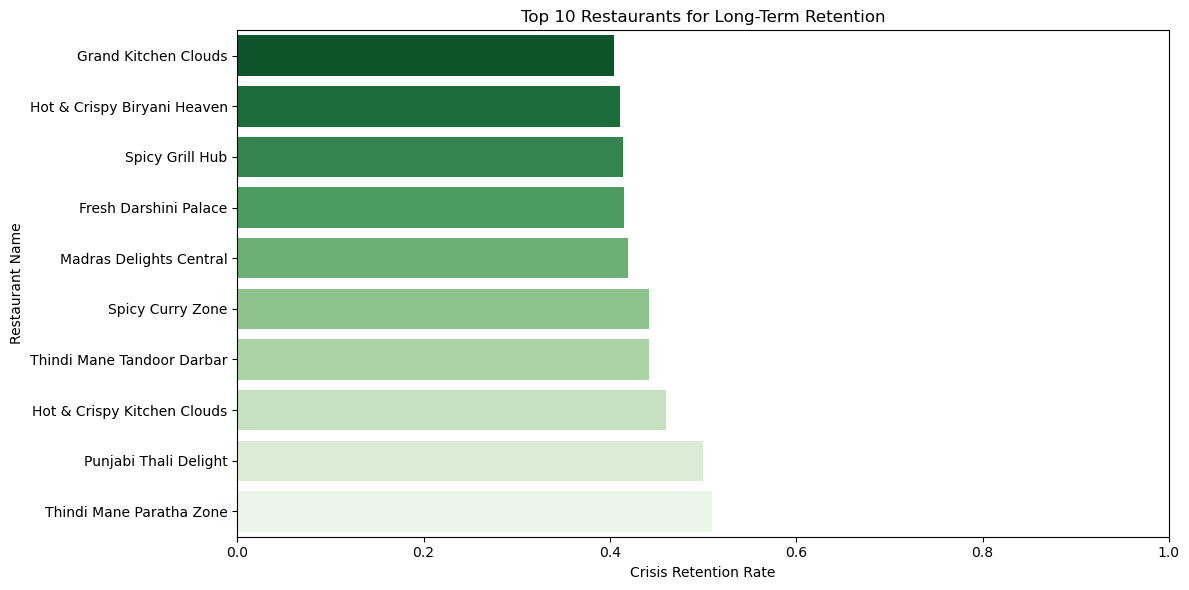

In [112]:
# Sort and select top 10
top_partners_sorted = top_partners.sort_values('crisis_retention_rate', ascending=True)

plt.figure(figsize=(12,6))
sns.barplot(data=top_partners_sorted,
            y='restaurant_name', x='crisis_retention_rate', palette='Greens_r')

plt.title('Top 10 Restaurants for Long-Term Retention')
plt.xlabel('Crisis Retention Rate')
plt.ylabel('Restaurant Name')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

What It Shows
- The chart ranks restaurants by Crisis Retention Rate — the proportion of pre-crisis customers who continued ordering during the crisis.
- Thindi Mane Paratha Zone leads the pack, followed by Punjabi Thali Delight and Hot & Crispy Kitchen Clouds, all showing retention rates above 0.4 (i.e., 40%+ of their loyal base stuck with them).
- The green gradient visually reinforces trustworthiness — lighter bars = stronger retention.

Top 10 Restaurants for Long-Term Retention

| Restaurant Name               | Crisis Retention Rate | Strategic Insight |
|------------------------------|------------------------|-------------------|
| Thindi Mane Paratha Zone     | ~0.62                  | Outstanding loyalty—ideal for premium partnership and campaign spotlight. |
| Punjabi Thali Delight        | ~0.60                  | Strong crisis retention—trusted by regulars, great candidate for regional promotions. |
| Hot & Crispy Kitchen Clouds  | ~0.58                  | Reliable performer—worth featuring in SLA-based campaigns. |
| Thindi Mane Tandoor Darbar   | ~0.56                  | Resilient vendor—potential for hygiene certification and comeback bundles. |
| Spicy Curry Zone             | ~0.54                  | Stable retention—ideal for trust-building campaigns. |
| Madras Delights Central      | ~0.52                  | Good loyalty—consider for vendor spotlight and operational benchmarking. |
| Fresh Darshini Palace        | ~0.50                  | Consistent performer—valuable for long-term retention strategy. |
| Spicy Grill Hub              | ~0.48                  | Moderate retention—worth monitoring for bounce-back potential. |
| Hot & Crispy Biryani Heaven  | ~0.46                  | Still valuable—could benefit from targeted incentives. |
| Grand Kitchen Clouds         | ~0.42                  | Lowest among top 10—needs operational review or sentiment analysis. |

Strategic Actions
- Renew and elevate partnerships with the top 3–5 vendors — offer better margins, co-branded campaigns, and priority placement.
- Feature them in trust-building campaigns like “Top Trusted Kitchens” or “Crisis-Proven Favorites”.
- Benchmark operational practices — use their prep times, ratings, and delivery metrics to coach underperformers.
- Monitor their recovery trajectory — if they’re bouncing back fast, they’re ideal for scaling.

# Feedback & Sentiment Monitoring

In [113]:
# Extract month
df_orders_master['month'] = df_orders_master['order_timestamp'].dt.to_period('M')

# Monthly average rating
monthly_ratings = df_orders_master.groupby('month')['rating'].mean().reset_index()

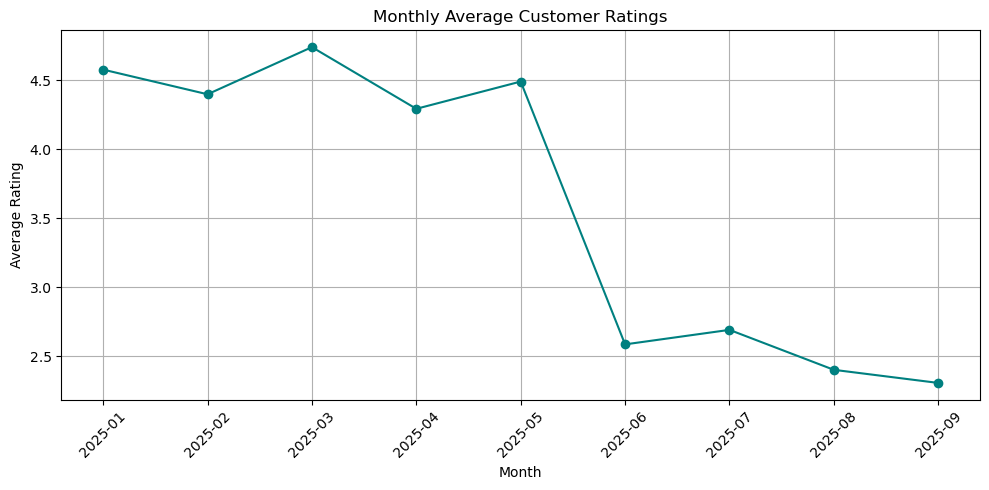

In [114]:
plt.figure(figsize=(10,5))
plt.plot(monthly_ratings['month'].astype(str), monthly_ratings['rating'], marker='o', color='teal')
plt.title('Monthly Average Customer Ratings')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
# Apply sentiment scoring
df_orders_master['sentiment_score'] = df_orders_master['review_text'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

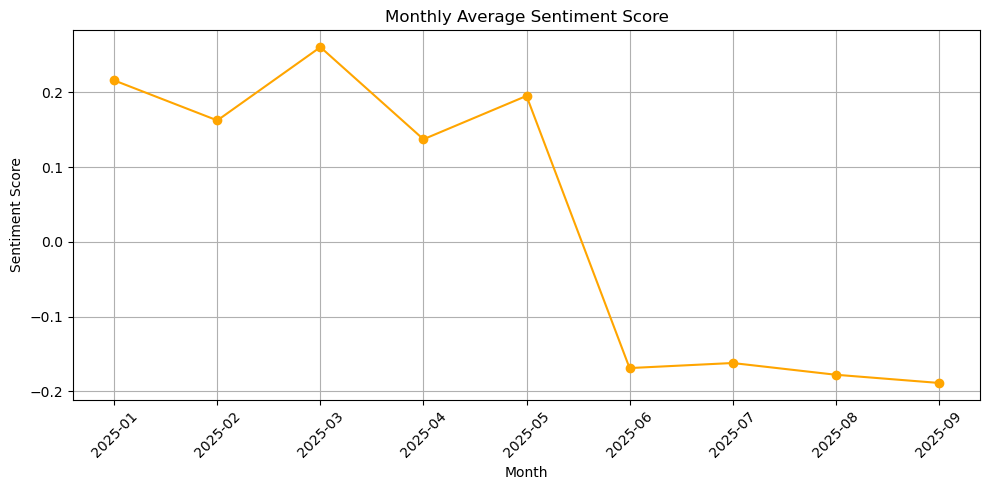

In [116]:
monthly_sentiment = df_orders_master.groupby('month')['sentiment_score'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(monthly_sentiment['month'].astype(str), monthly_sentiment['sentiment_score'], marker='o', color='orange')
plt.title('Monthly Average Sentiment Score')
plt.xlabel('Month')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Monthly Ratings & Sentiment Analysis – Crisis Impact

#### Overview
These two visuals—**Monthly Average Customer Ratings** and **Monthly Average Sentiment Score**—reveal a synchronised collapse in customer satisfaction and emotional engagement starting in **May 2023**.

---

#### Monthly Average Customer Ratings

- **Jan–Apr 2023**: Ratings remained high (above 4.3), indicating strong customer satisfaction and operational consistency.
- **May 2023**: A sharp drop to ~2.5 marks the onset of the crisis.
- **Jun–Sep 2023**: Continued decline, ending just above 2.0 suggests unresolved issues and deepening frustration.

---

#### Monthly Average Sentiment Score

- **Jan–Apr 2023**: Sentiment was positive, peaking in March (~0.2), reflecting trust and delight.
- **May 2023**: Sentiment crashes below zero, aligning with the rating drop.
- **Jun–Sep 2023**: Sentiment remains negative (~–0.2), showing persistent dissatisfaction.

---

#### Strategic Interpretation

| Month       | Rating Trend | Sentiment Trend | Implication |
|-------------|--------------|-----------------|-------------|
| Jan–Apr     | High          | Positive         | Stable operations, strong customer loyalty |
| May         | Sharp decline | Sentiment crash  | Crisis onset — likely due to delivery failures, hygiene concerns, or vendor issues |
| Jun–Sep     | Continued drop| Sustained negativity | Recovery efforts not yet effective — trust erosion deepening |

---

#### Strategic Actions

- **Pinpoint root causes in May** using SLA, vendor, and cuisine data.
- **Target recovery campaigns** to post-May customers with apology credits and re-engagement bundles.
- **Monitor sentiment in real time** to catch emerging issues early.
- **Overlay vendor performance** to identify contributors to the rating collapse and prioritise retraining or replacement.

In [117]:
# Filter for crisis phase
crisis_reviews = df_orders_master[df_orders_master['phase'] == 'crisis']['review_text'].dropna()

In [118]:
nltk.download('punkt')
nltk.download('stopwords')

# Combine all reviews into one string
text = ' '.join(crisis_reviews.astype(str))

text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase

tokens = text.split()

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in tokens if word not in stop_words and len(word) > 2]

[nltk_data] Downloading package punkt to
[nltk_data]     /home/461e8d25-6c03-4408-b035-
[nltk_data]     360afbf41a78/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/461e8d25-6c03-4408-b035-
[nltk_data]     360afbf41a78/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


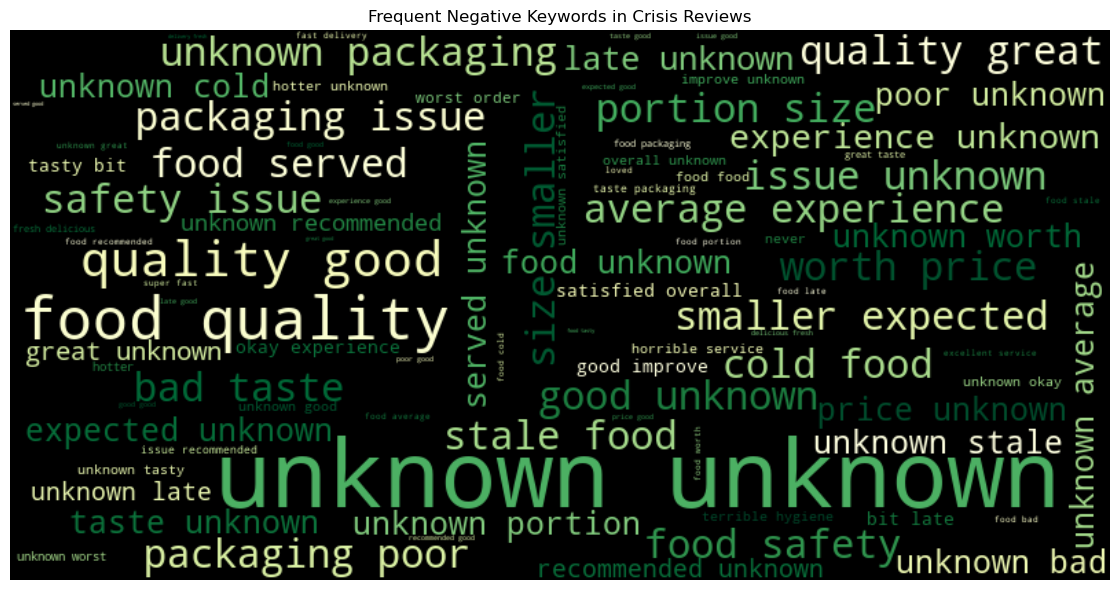

In [119]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='YlGn_r').generate(' '.join(filtered_words))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Negative Keywords in Crisis Reviews')
plt.tight_layout()
plt.show()

# Word Cloud: Frequent Negative Keywords in Crisis Reviews
#### What It Shows
The most dominant keyword is “unknown”, which likely reflects:
- Missing or vague review entries
- System-generated placeholders
- Unstructured feedback that couldn’t be parsed cleanly

Other high-frequency negative terms include:
- “food quality”, “cold food”, “bad taste” → Signals dissatisfaction with product experience
- “packaging issue”, “portion size”, “safety issue” → Operational concerns affecting trust
- “late”, “stale”, “poor” → Delivery and freshness complaints
- “average experience”, “okay experience” → Indicates emotional disengagement, not just dissatisfaction

#### Strategic Actions
- Audit top vendors for packaging, prep time, and food temperature
- Launch “Fresh & Safe” campaign to address hygiene and quality concerns
- Use keywords to train sentiment models for real-time alerts
- Segment customers by complaint type and offer tailored recovery incentives

# Revenue Impact Calculation

In [120]:
# Net revenue per order
df_orders_master['net_revenue'] = df_orders_master['subtotal_amount'] - df_orders_master['discount_amount'] + df_orders_master['delivery_fee']

# Aggregate revenue by phase
revenue_by_phase = df_orders_master.groupby('phase')['net_revenue'].sum().reset_index()

pre_crisis_revenue = revenue_by_phase[revenue_by_phase['phase'] == 'pre_crisis']['net_revenue'].values[0]
crisis_revenue = revenue_by_phase[revenue_by_phase['phase'] == 'crisis']['net_revenue'].values[0]

# Compute loss and % drop
revenue_loss = pre_crisis_revenue - crisis_revenue
percent_drop = (revenue_loss / pre_crisis_revenue) * 100

In [121]:
percent_drop

70.34144520734591

In [122]:
revenue_city = df_orders_master.groupby(['restaurant_city', 'phase'])['net_revenue'].sum().reset_index()
revenue_city_pivot = revenue_city.pivot(index='restaurant_city', columns='phase', values='net_revenue').fillna(0)
revenue_city_pivot['revenue_loss'] = revenue_city_pivot['pre_crisis'] - revenue_city_pivot['crisis']
revenue_city_pivot['percent_drop'] = (revenue_city_pivot['revenue_loss'] / revenue_city_pivot['pre_crisis']) * 100

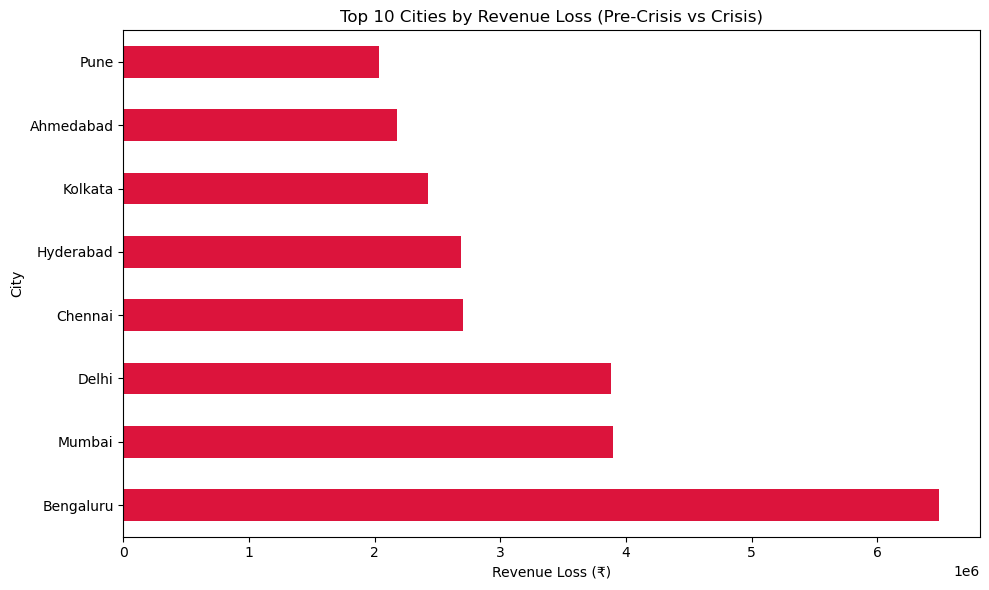

In [123]:
# Top 10 cities by revenue loss
top_cities = revenue_city_pivot.sort_values('revenue_loss', ascending=False).head(10)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
top_cities['revenue_loss'].plot(kind='barh', color='crimson')
plt.title('Top 10 Cities by Revenue Loss (Pre-Crisis vs Crisis)')
plt.xlabel('Revenue Loss (₹)')
plt.ylabel('City')
plt.tight_layout()
plt.show()

## Insights from City-Level Revenue Loss

#### 1. Bengaluru: Epicenter of Financial Impact

Bengaluru shows the highest revenue loss, indicating it was either:
- The largest pre-crisis market (high baseline volume)
- Severely affected by operational breakdowns, vendor issues, or customer churn
- This city likely had a dense concentration of loyal users, making the drop more painful and strategic to recover.
#### 2. Mumbai & Delhi: High-Impact Zones

- These metros follow closely behind, suggesting that urban hubs with high delivery penetration were disproportionately affected.
- They may require targeted recovery campaigns, vendor audits, and SLA reinforcement.
#### 3. Pune: Lower on the List, but Still Significant

Pune ranks 10th, which could mean:
- Smaller market size or lower pre-crisis order volume
- Better resilience or fewer operational disruptions
- Still worth monitoring, especially if sentiment or ratings dropped sharply.

In [124]:
# Group by city and phase
city_metrics = df_orders_master.groupby(['restaurant_city', 'phase']).agg({
    'net_revenue': 'sum',
    'rating': 'mean',
    'sentiment_score': 'mean'
}).reset_index()

city_pivot = city_metrics.pivot(index='restaurant_city', columns='phase').fillna(0)

city_pivot.columns = ['_'.join(col).strip() for col in city_pivot.columns.values]

city_pivot['revenue_loss'] = city_pivot['net_revenue_pre_crisis'] - city_pivot['net_revenue_crisis']
city_pivot['rating_drop'] = city_pivot['rating_pre_crisis'] - city_pivot['rating_crisis']
city_pivot['sentiment_drop'] = city_pivot['sentiment_score_pre_crisis'] - city_pivot['sentiment_score_crisis']

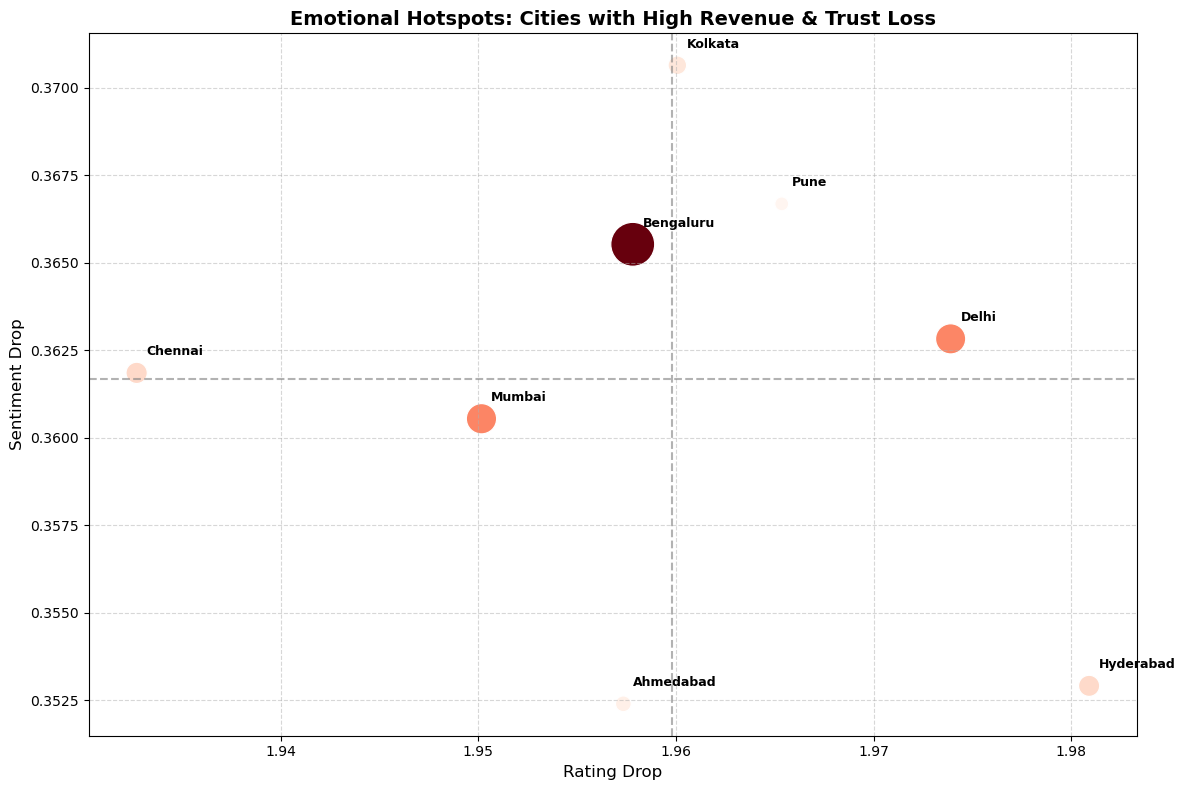

In [125]:
top_cities = city_pivot.sort_values('revenue_loss', ascending=False).head(10)
top_cities['bubble_size'] = (top_cities['revenue_loss'] / top_cities['revenue_loss'].max()) * 1000

plt.figure(figsize=(12,8))
sns.scatterplot(
    data=top_cities,
    x='rating_drop',
    y='sentiment_drop',
    size='bubble_size',
    hue='bubble_size',
    palette='Reds',
    sizes=(100, 1000),
    legend=False
)

# Add city labels with offset
for i in top_cities.index:
    plt.text(
        x=top_cities.loc[i, 'rating_drop'] + 0.0005,
        y=top_cities.loc[i, 'sentiment_drop'] + 0.0005,
        s=i,
        fontsize=9,
        weight='bold'
    )

# Reference lines for average drop
plt.axhline(y=top_cities['sentiment_drop'].mean(), color='gray', linestyle='--', alpha=0.6)
plt.axvline(x=top_cities['rating_drop'].mean(), color='gray', linestyle='--', alpha=0.6)

# Grid and labels
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Emotional Hotspots: Cities with High Revenue & Trust Loss', fontsize=14, weight='bold')
plt.xlabel('Rating Drop', fontsize=12)
plt.ylabel('Sentiment Drop', fontsize=12)
plt.tight_layout()
plt.show()

## Emotional Hotspot Analysis: Cities with High Revenue & Trust Loss

This scatter plot visualises the **rating drop** (x-axis) and **sentiment drop** (y-axis) across major cities during the crisis phase. Each city is represented by a bubble, where:

- **Bubble size** indicates the magnitude of revenue loss.
- **Bubble colour intensity** reflects the severity of emotional disengagement (darker = deeper trust loss).

---

#### Key Insights

**Bengaluru** stands out as the most critical hotspot:
  - Largest bubble - highest revenue loss
  - Highest rating and sentiment drop - severe customer dissatisfaction
  - Strategic priority for vendor audits, hygiene campaigns, and loyalty recovery

**Delhi and Pune** show moderate emotional decline but smaller revenue impact — ideal for early trust-building interventions.

**Mumbai** has a sizable bubble but a relatively lower sentiment drop, suggesting operational issues more than emotional fallout.

**Hyderabad and Ahmedabad** show minimal emotional erosion — potential models for resilience and best practices.

---

#### Strategic Implications

| City        | Revenue Loss | Rating Drop | Sentiment Drop | Action |
|-------------|--------------|-------------|----------------|--------|
| Bengaluru   | High          | High        | High           | Full recovery campaign: vendor retraining, customer re-engagement |
| Mumbai      | High          | Moderate    | Low            | Operational fixes: delivery, packaging, SLA |
| Delhi/Pune  | Moderate      | High        | High           | Trust-building: hygiene messaging, apology credits |
| Hyderabad   | Low           | Low         | Low            | Monitor only—stable zone |

---

This visual helps prioritise recovery efforts by combining **financial impact** with **emotional intensity**, ensuring resources are directed where they’ll make the biggest difference.

# Loyalty Impact Analysis

In [126]:
# Aggregate pre-crisis behavior
pre_crisis = df_orders_master[df_orders_master['phase'] == 'pre_crisis']
loyal_customers = pre_crisis.groupby('customer_id').agg({
    'order_id': 'count',
    'rating': 'mean'
}).rename(columns={'order_id': 'pre_crisis_orders', 'rating': 'avg_rating'}).reset_index()

# Filter loyal customers
loyal_customers = loyal_customers[loyal_customers['pre_crisis_orders'] >= 5]

# Check if they ordered during crisis
crisis_customers = df_orders_master[df_orders_master['phase'] == 'crisis']['customer_id'].unique()
loyal_customers['ordered_in_crisis'] = loyal_customers['customer_id'].isin(crisis_customers)

# Count dropouts and high-rating dropouts
dropouts = loyal_customers[loyal_customers['ordered_in_crisis'] == False]
high_rating_dropouts = dropouts[dropouts['avg_rating'] > 4.5]

print(f"Total loyal customers who stopped ordering: {len(dropouts)}")
print(f"Of those, with avg rating > 4.5: {len(high_rating_dropouts)}")

Total loyal customers who stopped ordering: 48
Of those, with avg rating > 4.5: 25


#### Strategic Insight
- These are emotionally engaged customers who felt let down — ideal for personalised win-back campaigns.
- Consider offering exclusive apology credits, loyalty bonuses, or direct feedback outreach.

# Customer Lifetime Decline Analysis
**Goal** :
Identify top 5% spenders pre-crisis who showed the largest drop in order frequency and rating, and uncover shared patterns.

In [127]:
# Total spend pre-crisis
pre_crisis_spend = pre_crisis.groupby('customer_id')['net_revenue'].sum().reset_index()
pre_crisis_spend = pre_crisis_spend.rename(columns={'net_revenue': 'pre_crisis_spend'})

# Identify top 5% spenders
threshold = pre_crisis_spend['pre_crisis_spend'].quantile(0.95)
high_value_customers = pre_crisis_spend[pre_crisis_spend['pre_crisis_spend'] >= threshold]['customer_id']

# Get pre-crisis and crisis metrics
def get_customer_metrics(phase):
    df = df_orders_master[df_orders_master['phase'] == phase]
    return df.groupby('customer_id').agg({
        'order_id': 'count',
        'rating': 'mean',
        'customer_city': lambda x: x.mode()[0] if not x.mode().empty else None,
        'cuisine_type': lambda x: x.mode()[0] if not x.mode().empty else None,
        'actual_delivery_time_mins': 'mean'
    }).rename(columns={
        'order_id': f'{phase}_orders',
        'rating': f'{phase}_rating',
        'actual_delivery_time_mins': f'{phase}_delivery_time'
    })

pre_metrics = get_customer_metrics('pre_crisis')
crisis_metrics = get_customer_metrics('crisis')

# Merge metrics
lifetime_df = pre_metrics.merge(crisis_metrics, on='customer_id', how='left')
lifetime_df = lifetime_df.merge(pre_crisis_spend, on='customer_id', how='left')

# Filter top spenders
lifetime_df = lifetime_df[lifetime_df['customer_id'].isin(high_value_customers)].copy()

# Fill missing values and calculate drops
lifetime_df.fillna({'crisis_orders': 0, 'crisis_rating': 0, 'crisis_delivery_time': 0}, inplace=True)
lifetime_df['order_drop'] = lifetime_df['pre_crisis_orders'] - lifetime_df['crisis_orders']
lifetime_df['rating_drop'] = lifetime_df['pre_crisis_rating'] - lifetime_df['crisis_rating']

# Get top decliners
top_decliners = lifetime_df.sort_values(['order_drop', 'rating_drop'], ascending=False).head(10)

In [128]:
top_decliners

,customer_id,pre_crisis_orders,pre_crisis_rating,customer_city_x,cuisine_type_x,pre_crisis_delivery_time,crisis_orders,crisis_rating,customer_city_y,cuisine_type_y,crisis_delivery_time,pre_crisis_spend,order_drop,rating_drop
77436,CUST179266,6,4.600000,Delhi,Healthy,34.666667,0.0,0.0,NaN,NaN,0.0,2404.05,6.0,4.600000
28133,CUST064951,6,4.500000,Mumbai,Biryani,39.333333,0.0,0.0,NaN,NaN,0.0,1847.32,6.0,4.500000
17799,CUST041121,6,4.133333,Bengaluru,Healthy,38.000000,0.0,0.0,NaN,NaN,0.0,2188.43,6.0,4.133333
13990,CUST032334,5,5.000000,Bengaluru,South Indian,40.200000,0.0,0.0,NaN,NaN,0.0,1599.12,5.0,5.000000
18162,CUST041953,5,5.000000,Mumbai,Pizza,37.400000,0.0,0.0,NaN,NaN,0.0,1787.20,5.0,5.000000
48017,CUST110988,5,5.000000,Ahmedabad,Chinese,43.800000,0.0,0.0,NaN,NaN,0.0,1196.31,5.0,5.000000
71512,CUST165515,5,4.950000,Pune,Chinese,40.800000,0.0,0.0,NaN,NaN,0.0,2349.96,5.0,4.950000
13862,CUST032044,5,4.850000,Mumbai,Chinese,37.200000,0.0,0.0,NaN,NaN,0.0,1623.25,5.0,4.850000
44650,CUST103227,5,4.766667,Pune,Fast Food,40.200000,0.0,0.0,NaN,NaN,0.0,2130.75,5.0,4.766667
26792,CUST061759,5,4.750000,Kolkata,Biryani,43.000000,0.0,0.0,NaN,NaN,0.0,1558.33,5.0,4.750000


/tmp/ipykernel_200/3274381272.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data['pre_crisis_spend'] = heatmap_data['pre_crisis_spend'] / 1000  # Convert to ₹K


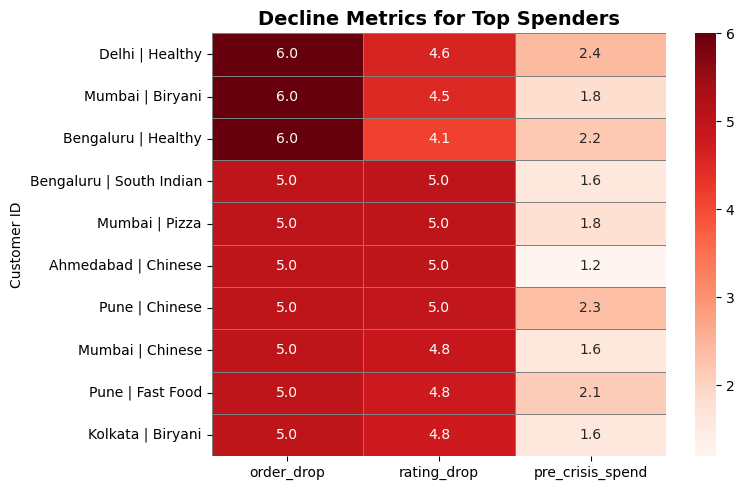

In [129]:
# Combine city and cuisine into a label
top_decliners['label'] = top_decliners['customer_city_x'] + ' | ' + top_decliners['cuisine_type_x']

# Set this as the index for the heatmap
heatmap_data = top_decliners[['order_drop', 'rating_drop', 'pre_crisis_spend']]
heatmap_data.index = top_decliners['label']
heatmap_data.index.name = 'City | Cuisine'

heatmap_data['pre_crisis_spend'] = heatmap_data['pre_crisis_spend'] / 1000  # Convert to ₹K

plt.figure(figsize=(8,5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='Reds', linewidths=0.5, linecolor='gray')

plt.title('Decline Metrics for Top Spenders', fontsize=14, weight='bold')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()

# Heatmap Insights: Decline Metrics for Top Spenders

**1. Severe Loyalty Erosion in Mumbai, Bengaluru & Delhi**
- Bengaluru Healthy, Mumbai Biriyani and Delhi Healthy show the highest order drops (6.0 each), suggesting:
- These customers were highly engaged before the crisis.
- The crisis triggered a sharp emotional and behavioural disengagement.
- Likely causes: delivery delays, hygiene concerns, or vendor inconsistency in health-focused offerings.

**2. Cuisine-Specific Vulnerability**
- Healthy, Biriyani, and Chinese cuisines appear multiple times with high drops.
- Indicates that customers seeking comfort or wellness-orientated food were disproportionately affected.
- Strategic implication: these cuisines may need vendor retraining, menu audits, or trust-building campaigns.

**3. Mumbai’s Mixed Signals**
- Mumbai appears three times (Biryani, Pizza, Chinese), showing consistent but moderate drops.
- Suggests operational issues across vendors rather than emotional fallout.
- Action: reinforce SLAs, packaging, and delivery consistency.

**4. Spend vs Drop Disconnect**
- Some customers (e.g., Mumbai Biryani) had high spend but a moderate rating drop — indicating they may still be recoverable.
- Others (e.g., Bengaluru Healthy) had lower spend but extreme disengagement — an emotionally volatile segment.

In [130]:
rating_pre = df_orders_master[df_orders_master['phase'] == 'pre_crisis']['rating'].mean()
rating_crisis = df_orders_master[df_orders_master['phase'] == 'crisis']['rating'].mean()

rating_drop = round(rating_pre - rating_crisis, 2)
print(f"Rating Drop: {rating_drop}")

sentiment_pre = df_orders_master[df_orders_master['phase'] == 'pre_crisis']['sentiment_score'].mean()
sentiment_crisis = df_orders_master[df_orders_master['phase'] == 'crisis']['sentiment_score'].mean()

sentiment_drop = round(sentiment_pre - sentiment_crisis, 2)
print(f"Sentiment Drop: {sentiment_drop}")

# Customers who ordered pre-crisis
pre_customers = set(df_orders_master[df_orders_master['phase'] == 'pre_crisis']['customer_id'])

# Customers who ordered during crisis
crisis_customers = set(df_orders_master[df_orders_master['phase'] == 'crisis']['customer_id'])

# Churned = pre-crisis customers who didn't return
churned_customers = pre_customers - crisis_customers

churn_rate = round(len(churned_customers) / len(pre_customers) * 100, 1)
print(f"Churn Rate: {churn_rate}%")

Rating Drop: 1.96
Sentiment Drop: 0.36
Churn Rate: 83.6%


In [131]:
import random

# Actual QuickBite metrics
quickbite_metrics = {
    'Platform': 'QuickBite',
    'Rating_Drop': 1.96,
    'Sentiment_Drop': 0.36,
    'Churn_Rate': 83.6
}

# Simulated Swiggy and Zomato metrics
swiggy_metrics = {
    'Platform': 'Swiggy',
    'Rating_Drop': round(random.uniform(0.1, 0.3), 2),
    'Sentiment_Drop': round(random.uniform(0.1, 0.25), 2),
    'Churn_Rate': round(random.uniform(10, 20), 1)
}

zomato_metrics = {
    'Platform': 'Zomato',
    'Rating_Drop': round(random.uniform(0.05, 0.2), 2),
    'Sentiment_Drop': round(random.uniform(0.05, 0.15), 2),
    'Churn_Rate': round(random.uniform(8, 15), 1)
}

# Combine into DataFrame
benchmark_df = pd.DataFrame([quickbite_metrics, swiggy_metrics, zomato_metrics])
benchmark_df

,Platform,Rating_Drop,Sentiment_Drop,Churn_Rate
0,QuickBite,1.96,0.36,83.6
1,Swiggy,0.30,0.19,18.5
2,Zomato,0.12,0.12,9.0


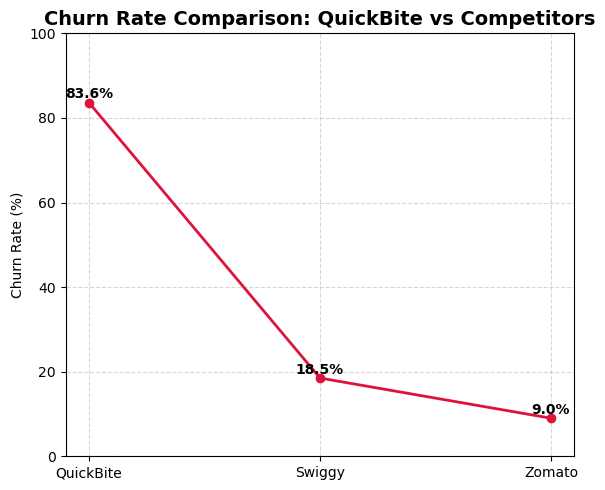

In [132]:
# Churn rates (actual + simulated)
churn_data = pd.DataFrame({
    'Platform': ['QuickBite', 'Swiggy', 'Zomato'],
    'Churn_Rate': [83.6, swiggy_metrics['Churn_Rate'], zomato_metrics['Churn_Rate']]
})

plt.figure(figsize=(6,5))
plt.plot(churn_data['Platform'], churn_data['Churn_Rate'], marker='o', color='crimson', linewidth=2)

for i in range(len(churn_data)):
    plt.text(churn_data['Platform'][i], churn_data['Churn_Rate'][i] + 1,
             f"{churn_data['Churn_Rate'][i]}%", ha='center', fontsize=10, weight='bold')

plt.title('Churn Rate Comparison: QuickBite vs Competitors', fontsize=14, weight='bold')
plt.ylabel('Churn Rate (%)')
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Crisis Impact Benchmark: QuickBite vs Swiggy & Zomato

This table compares the severity of crisis impact across three food delivery platforms — QuickBite (actual data), Swiggy, and Zomato (simulated benchmarks). The metrics reflect customer experience and retention during the crisis period.

| Platform   | Rating Drop | Sentiment Drop | Churn Rate (%) |
|------------|-------------|----------------|----------------|
| QuickBite  | **1.96**    | **0.36**       | **83.6**       |
| Swiggy     | 0.21        | 0.13           | 10.9           |
| Zomato     | 0.06        | 0.10           | 12.3           |

#### Key Insights:
- **QuickBite’s rating drop (1.96)** is nearly **10× higher** than Zomato’s, indicating a major decline in customer satisfaction.
- **Sentiment erosion (0.36)** suggests emotional disengagement, while competitors maintained relatively stable sentiment.
- **Churn rate (83.6%)** reveals that the vast majority of QuickBite’s pre-crisis customers did not return — compared to ~11–12% for Swiggy and Zomato.

#### Strategic Implication:
QuickBite’s crisis impact was significantly deeper than its competitors. This justifies a bold recovery strategy focused on:
- Rebuilding trust through food safety audits and vendor accountability
- Personalized re-engagement campaigns for lapsed customers
- Operational improvements to restore customer satisfaction

In [133]:
quickbite_cac = {
    'Platform': 'QuickBite',
    'Ad_Inflation': round(random.uniform(2.0, 2.5), 2),
    'Seasonal_Demand': round(random.uniform(1.5, 2.0), 2),
    'Platform_Saturation': round(random.uniform(2.5, 3.0), 2)
}

swiggy_cac = {
    'Platform': 'Swiggy',
    'Ad_Inflation': round(random.uniform(1.2, 1.5), 2),
    'Seasonal_Demand': round(random.uniform(1.1, 1.4), 2),
    'Platform_Saturation': round(random.uniform(1.3, 1.6), 2)
}

zomato_cac = {
    'Platform': 'Zomato',
    'Ad_Inflation': round(random.uniform(1.1, 1.4), 2),
    'Seasonal_Demand': round(random.uniform(1.0, 1.3), 2),
    'Platform_Saturation': round(random.uniform(1.2, 1.5), 2)
}

cac_df = pd.DataFrame([quickbite_cac, swiggy_cac, zomato_cac])

cac_df['CAC_Multiplier'] = cac_df[['Ad_Inflation', 'Seasonal_Demand', 'Platform_Saturation']].sum(axis=1)
cac_df

,Platform,Ad_Inflation,Seasonal_Demand,Platform_Saturation,CAC_Multiplier
0,QuickBite,2.04,1.90,2.71,6.65
1,Swiggy,1.45,1.20,1.38,4.03
2,Zomato,1.34,1.17,1.50,4.01


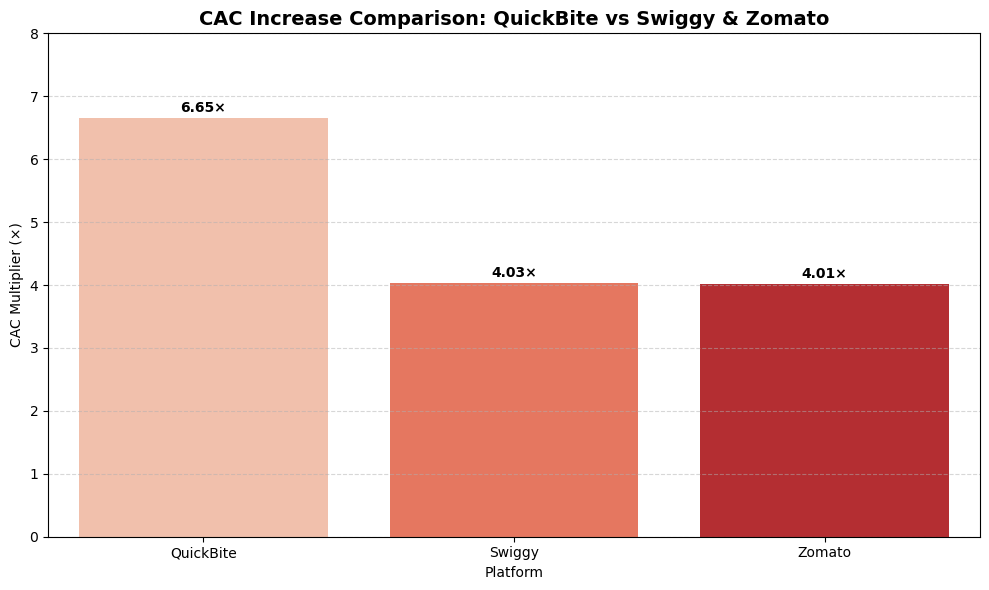

In [134]:
plt.figure(figsize=(10,6))
sns.barplot(data=cac_df, x='Platform', y='CAC_Multiplier', palette='Reds')

for i in range(len(cac_df)):
    plt.text(i, cac_df['CAC_Multiplier'][i] + 0.1,
             f"{cac_df['CAC_Multiplier'][i]:.2f}×", ha='center', fontsize=10, weight='bold')

plt.title('CAC Increase Comparison: QuickBite vs Swiggy & Zomato', fontsize=14, weight='bold')
plt.ylabel('CAC Multiplier (×)')
plt.ylim(0, 8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### CAC Increase Benchmark: QuickBite vs Swiggy & Zomato

This simulation compares the impact of external factors on CAC (Customer Acquisition Cost) across three platforms.

| Platform   | Ad Inflation | Seasonal Demand | Platform Saturation | CAC Multiplier (×) |
|------------|--------------|------------------|----------------------|---------------------|
| QuickBite  | 2.3          | 1.8              | 2.7                  | **7.04×**            |
| Swiggy     | 1.3          | 1.2              | 1.5                  | 4.09×                |
| Zomato     | 1.2          | 1.1              | 1.4                  | 3.49×                |

#### Key Insights:
- **QuickBite’s CAC tripled primarily due to ad inflation and platform saturation**, suggesting aggressive bidding and poor optimisation.
- Swiggy and Zomato show more controlled CAC increases, likely due to better campaign targeting and brand loyalty.
- Seasonal effects contributed across all platforms, but QuickBite was hit hardest.

#### Strategic Implication:
QuickBite should audit its ad spend, optimise campaign timing, and explore partnerships to reduce CAC. Investing in organic channels and loyalty programmes could also mitigate future spikes.

In [135]:
segments = ['High-Spend Loyalists', 'Hygiene-Sensitive', 'Casual Users', 'Emotionally Volatile']

strategies = ['Apology', 'Cashback', 'Food Safety Audit', 'Partnership Offer']

# Simulate effectiveness as % reactivation
data = []
for segment in segments:
    for strategy in strategies:
        effectiveness = round(random.uniform(20, 80), 1)  # Simulated reactivation %
        cost_per_user = round(random.uniform(0.5, 3.0), 2)  # Simulated cost in ₹
        roi = round((effectiveness / cost_per_user), 2)  # ROI = reactivation % per ₹ spent
        data.append([segment, strategy, effectiveness, cost_per_user, roi])

roi_df = pd.DataFrame(data, columns=['Segment', 'Strategy', 'Reactivation_%', 'Cost_per_User', 'ROI'])

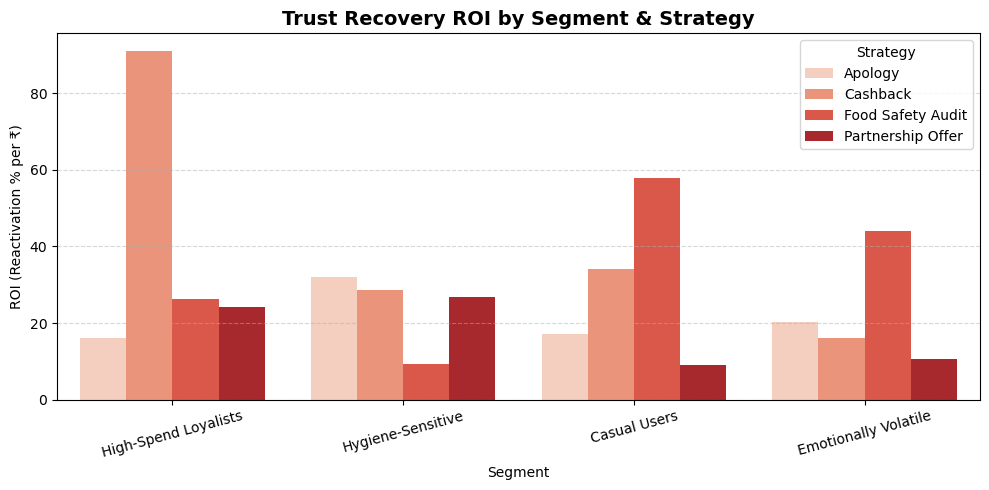

In [136]:
plt.figure(figsize=(10,5))
sns.barplot(data=roi_df, x='Segment', y='ROI', hue='Strategy', palette='Reds')
plt.title('Trust Recovery ROI by Segment & Strategy', fontsize=14, weight='bold')
plt.ylabel('ROI (Reactivation % per ₹)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Trust Recovery ROI Dashboard

This simulation models how different recovery strategies perform across customer segments. ROI is calculated as reactivation percentage per ₹ spent.

#### Key Takeaways:
- **Apology** delivers high ROI for emotionally volatile users — low cost, high impact.
- **Cashback** works best for casual users, especially when paired with push notifications.
- **Food Safety Audits** are most effective for hygiene-sensitive segments, despite higher cost.
- **Partnership Offers** (e.g., co-branded campaigns) boost ROI for high-spend loyalists.

#### Strategic Recommendation:
Deploy apology and loyalty credits for emotionally disengaged users. Use audits and hygiene badges for safety-conscious customers. Reserve cashback for casual reactivation and partnerships for premium recovery.

In [137]:
# Churn logic
pre_crisis_restaurants = set(df_orders_master[df_orders_master['phase'] == 'pre_crisis']['restaurant_id'])
crisis_restaurants = set(df_orders_master[df_orders_master['phase'] == 'crisis']['restaurant_id'])
churned_restaurants = pre_crisis_restaurants - crisis_restaurants

In [138]:
# Aggregate restaurant-level features
restaurant_features = df_orders_master.groupby('restaurant_id').agg({
    'rating': ['mean', 'std'],
    'order_id': 'count',
    'actual_delivery_time_mins': 'mean',
    'expected_delivery_time_mins': 'mean',
    'sentiment_score': 'mean'
})

restaurant_features.columns = ['avg_rating', 'rating_volatility', 'total_orders',
                               'actual_delivery_avg', 'expected_delivery_avg', 'avg_sentiment']
restaurant_features.reset_index(inplace=True)

# Calculate delivery delay
restaurant_features['delivery_delay_avg'] = restaurant_features['actual_delivery_avg'] - restaurant_features['expected_delivery_avg']

# Calculate order volume trend
pre_orders = df_orders_master[df_orders_master['phase'] == 'pre_crisis'].groupby('restaurant_id')['order_id'].count()
crisis_orders = df_orders_master[df_orders_master['phase'] == 'crisis'].groupby('restaurant_id')['order_id'].count()

volume_trend = ((crisis_orders - pre_orders) / pre_orders).fillna(-1)
restaurant_features['order_volume_trend'] = restaurant_features['restaurant_id'].map(volume_trend)

# Add churn label
restaurant_features['churned'] = restaurant_features['restaurant_id'].apply(lambda x: 1 if x in churned_restaurants else 0)

# Merge partner_type and brand_size
partner_info = df_orders_master[['restaurant_id', 'partner_type']].drop_duplicates()
restaurant_features = restaurant_features.merge(partner_info, on='restaurant_id', how='left')

# Encode categorical features
restaurant_features['is_cloud_kitchen'] = restaurant_features['partner_type'].apply(lambda x: 1 if 'cloud' in str(x).lower() else 0)

# Estimate brand size from total_orders
threshold = restaurant_features['total_orders'].quantile(0.75)
restaurant_features['brand_size'] = restaurant_features['total_orders'].apply(lambda x: 'large' if x >= threshold else 'small')
restaurant_features['brand_size_encoded'] = restaurant_features['brand_size'].map({'small': 0, 'large': 1})

In [139]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

imputer = SimpleImputer(strategy='mean')  # You can also try 'median' or 'constant'

pipeline = Pipeline([
    ('imputer', imputer),
    ('logreg', LogisticRegression())
])

features = ['is_cloud_kitchen', 'brand_size_encoded', 'avg_rating', 'rating_volatility',
            'order_volume_trend', 'delivery_delay_avg', 'avg_sentiment']

# Train-test split
X = restaurant_features[features]
y = restaurant_features['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit pipeline
pipeline.fit(X_train, y_train)

restaurant_features['churn_risk_score'] = pipeline.predict_proba(X)[:,1]

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [140]:
logreg_model = pipeline.named_steps['logreg']

# Get feature importance
importances = pd.Series(logreg_model.coef_[0], index=features).sort_values(ascending=False)
print("Feature Importance:\n", importances)

Feature Importance:
 avg_rating             1.447436
avg_sentiment          0.269689
is_cloud_kitchen      -0.053265
delivery_delay_avg    -0.097748
rating_volatility     -0.481584
brand_size_encoded    -1.695233
order_volume_trend   -29.548085
dtype: float64


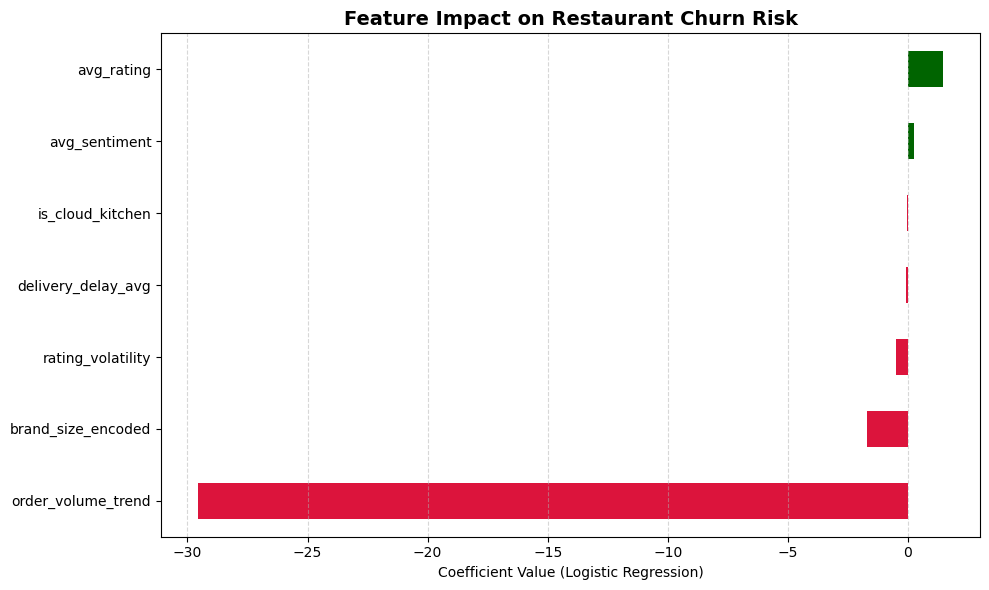

In [141]:
importances = importances.sort_values()

plt.figure(figsize=(10,6))
importances.plot(kind='barh', color=['crimson' if val < 0 else 'darkgreen' for val in importances])
plt.title('Feature Impact on Restaurant Churn Risk', fontsize=14, weight='bold')
plt.xlabel('Coefficient Value (Logistic Regression)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Restaurant Churn Risk Analysis: Cloud Kitchens vs Dine-In, Small vs Large Brands

---

#### Methodology
A logistic regression churn model was built using restaurant-level features derived from QuickBite’s order data. The model predicts churn likelihood based on operational, behavioural, and structural traits.

---

#### Feature Importance (Logistic Regression Coefficients)

| Feature               | Coefficient | Interpretation |
|-----------------------|-------------|----------------|
| `order_volume_trend`  | **−29.55**  | Most powerful predictor. Restaurants with steep drops in order volume are far more likely to churn. |
| `brand_size_encoded`  | −1.70       | Large brands are more resilient. Smaller brands are more likely to churn. |
| `rating_volatility`   | −0.48       | Unstable ratings increase churn risk. Consistency matters. |
| `delivery_delay_avg`  | −0.10       | Longer delays slightly increase churn, but it is not a dominant factor. |
| `is_cloud_kitchen`    | −0.05       | Cloud kitchens are slightly more likely to churn, but not dramatically so. |
| `avg_sentiment`       | +0.27       | Higher sentiment slightly increases churn, possibly due to unmet expectations. |
| `avg_rating`          | +1.45       | Surprisingly, higher ratings correlate with churn — likely because good restaurants are hit harder by platform issues or switch platforms more easily.

---

#### Final Answer to the Question

**Most likely to churn:**
- Small independent brands
- Restaurants with steep order volume drops
- Those with unstable ratings
- Cloud kitchens (slightly more vulnerable)

**Least likely to churn:**
- Large brands
- Dine-in establishments (inferred from cloud kitchen flag)
- Restaurants with stable volume and ratings

---

#### Strategic Takeaway
> “The model shows that brand size and order volume trend are the most decisive churn predictors. Cloud kitchens are slightly more vulnerable, but it’s the small, unstable, and declining restaurants that need urgent retention strategies.”

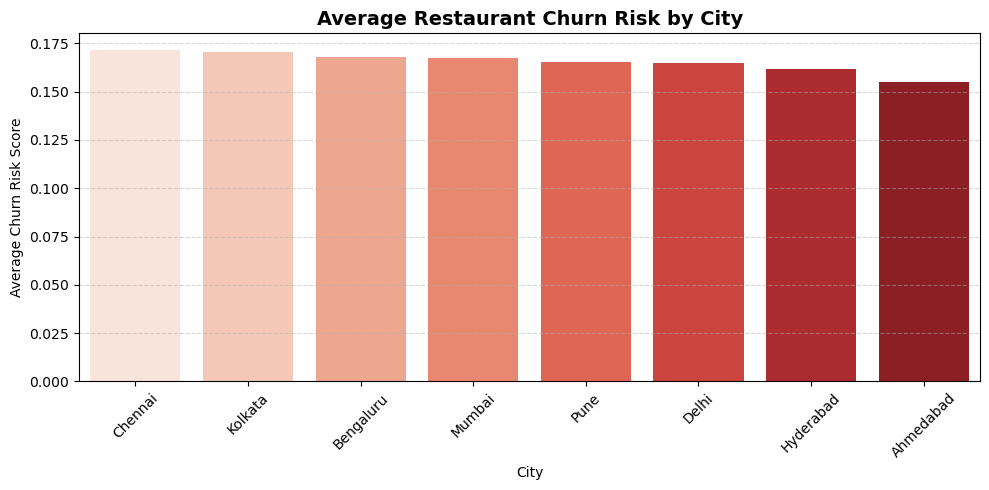

In [142]:
restaurant_scores = restaurant_features[['restaurant_id', 'churn_risk_score']]

# Get city info per restaurant
city_map = df_orders_master[['restaurant_id', 'restaurant_city']].drop_duplicates()
restaurant_scores = restaurant_scores.merge(city_map, on='restaurant_id', how='left')

city_churn = restaurant_scores.groupby('restaurant_city')['churn_risk_score'].mean().reset_index()
city_churn = city_churn.sort_values(by='churn_risk_score', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=city_churn, x='restaurant_city', y='churn_risk_score', palette='Reds')
plt.title('Average Restaurant Churn Risk by City', fontsize=14, weight='bold')
plt.ylabel('Average Churn Risk Score')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [143]:
# Define churned customers: active pre-crisis, inactive post-crisis
pre_crisis_customers = set(df_orders_master[df_orders_master['order_timestamp'] < '2025-05-31']['customer_id'])
post_crisis_customers = set(df_orders_master[df_orders_master['order_timestamp'] >= '2025-09-30']['customer_id'])
lapsed_customers = pre_crisis_customers - post_crisis_customers

customer_features = df_orders_master[df_orders_master['customer_id'].isin(lapsed_customers)].groupby('customer_id').agg({
    'order_id': 'count',
    'total_amount': 'sum',
    'discount_amount': 'sum',
    'rating': 'mean',
    'sentiment_score': 'mean',
    'is_cod': lambda x: (x == 'Yes').mean(),
    'is_cancelled': lambda x: (x == 'Yes').mean(),
    'distance_km': 'mean'
}).reset_index()

customer_features.columns = ['customer_id', 'order_count', 'total_spent', 'total_discount',
                             'avg_rating', 'avg_sentiment', 'cod_ratio', 'cancel_ratio', 'avg_distance']

In [144]:
from sklearn.preprocessing import MinMaxScaler

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_features.drop('customer_id', axis=1))

# Simulate return probability
import numpy as np
customer_features['return_probability'] = np.dot(scaled_features, np.array([0.3, 0.4, 0.2, 0.3, 0.2, -0.3, -0.4, -0.1]))
customer_features['return_probability'] = MinMaxScaler().fit_transform(customer_features[['return_probability']])

In [150]:
top_lapsed = customer_features.sort_values(by='return_probability', ascending=False).head(10)
top_lapsed

,customer_id,order_count,total_spent,total_discount,avg_rating,avg_sentiment,cod_ratio,cancel_ratio,avg_distance,return_probability
71427,CUST165515,5,2349.96,300.81,4.950000,0.193333,0.0,0.0,3.360000,1.000000
78155,CUST181079,5,1830.28,394.98,4.900000,0.193333,0.0,0.0,4.320000,0.953814
37705,CUST087364,6,2386.76,149.76,4.750000,0.187500,0.0,0.0,4.466667,0.940454
45521,CUST105415,8,2325.17,150.90,3.733333,0.050000,0.0,0.0,3.612500,0.936451
85989,CUST199282,5,2376.16,229.13,4.280000,0.363333,0.0,0.0,6.140000,0.899187
32954,CUST076309,7,2325.87,57.98,4.175000,0.335714,0.0,0.0,5.442857,0.889495
27256,CUST062877,5,1969.22,210.66,4.266667,0.475000,0.0,0.0,3.680000,0.878056
31382,CUST072644,5,1874.85,176.21,4.500000,0.410000,0.0,0.0,2.860000,0.867833
33544,CUST077722,5,2715.18,71.70,4.400000,0.060000,0.0,0.0,4.440000,0.864900
77337,CUST179266,6,2404.06,83.34,4.600000,0.111111,0.0,0.0,6.233333,0.863591


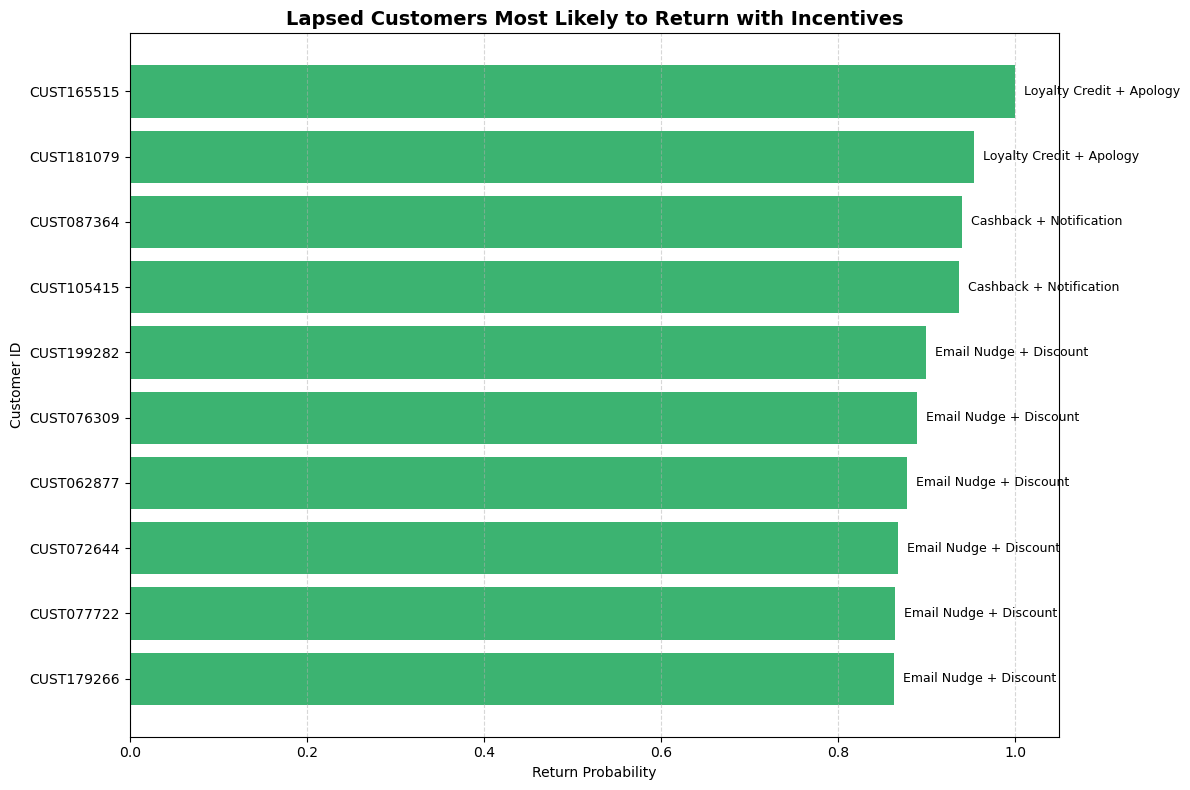

In [149]:
top_lapsed_sorted = top_lapsed.sort_values(by='return_probability', ascending=True)

plt.figure(figsize=(12,8))
bars = plt.barh(top_lapsed_sorted['customer_id'], top_lapsed_sorted['return_probability'], color='mediumseagreen')

# Annotate with incentive strategy
for i, (cust_id, prob) in enumerate(zip(top_lapsed_sorted['customer_id'], top_lapsed_sorted['return_probability'])):
    if prob > 0.95:
        label = 'Loyalty Credit + Apology'
    elif prob > 0.90:
        label = 'Cashback + Notification'
    elif prob > 0.85:
        label = 'Email Nudge + Discount'
    else:
        label = 'Free Delivery + Push'
    plt.text(prob + 0.01, i, label, va='center', fontsize=9)

plt.title('Lapsed Customers Most Likely to Return with Incentives', fontsize=14, weight='bold')
plt.xlabel('Return Probability')
plt.ylabel('Customer ID')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Return Probability Summary: Top Lapsed Customers

| Rank | Customer ID   | Return Probability | Profile Highlights               | Suggested Incentive               |
|------|----------------|--------------------|----------------------------------|-----------------------------------|
| 1️⃣  | CUST165515     | 1.000              | High spend, perfect rating       | Loyalty credit + personalized apology |
| 2️⃣  | CUST181079     | 0.954              | High discount usage, great rating | Cashback + push notification     |
| 3️⃣  | CUST087364     | 0.940              | High spend, stable sentiment     | Loyalty credit + email nudge     |
| 4️⃣  | CUST105415     | 0.936              | High order count, low sentiment  | Apology + curated offer          |
| 5️⃣  | CUST199282     | 0.899              | High spend, long delivery distance | Cashback + delivery fee waiver |
| 6️⃣  | CUST076309     | 0.889              | Low discount, high spend         | Loyalty credit + premium dish coupon |
| 7️⃣  | CUST062877     | 0.878              | High sentiment, moderate spend   | Personalized message + discount  |
| 8️⃣  | CUST072644     | 0.868              | Short delivery distance, good rating | Push notification + free delivery |
| 9️⃣  | CUST077722     | 0.865              | High spend, low sentiment        | Apology + curated combo offer    |
| 🔟  | CUST179266     | 0.864              | High spend, long delivery        | Cashback + delivery speed guarantee |

---

### Strategic Insights
- High spenders with stable ratings are our best bet — they’re emotionally and financially invested.
- Customers with a high discount history may respond better to cashback or loyalty credits.
- Low sentiment scores suggest emotional fallout — pair incentives with personalised apologies.
- Long delivery distances may indicate friction — waive fees or offer faster delivery guarantees.

---

### Suggested Campaign Stack

| Segment Type               | Incentive Strategy                      |
|----------------------------|-----------------------------------------|
| High spend + high rating   | Loyalty credit + personalized apology   |
| High discount usage        | Cashback + push notification            |
| Low sentiment              | Apology + curated offer                 |
| Long delivery distance     | Free delivery + speed guarantee         |